In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.special import hermite, factorial

from pde_classes import *

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device {device}")

Using device mps


Epoch 0
    E = 0.5, norm = 2.503e+00, loss = 3.760e+01
    loss_pde = 2.870e+01, loss_bc = 3.265e-01, loss_norm = 8.571e+00
Epoch 100
    E = 0.5, norm = 8.738e-01, loss = 2.139e-01
    loss_pde = 1.968e-01, loss_bc = 1.137e-03, loss_norm = 1.604e-02
Epoch 200
    E = 0.5, norm = 9.120e-01, loss = 1.294e-01
    loss_pde = 1.209e-01, loss_bc = 6.641e-04, loss_norm = 7.783e-03
Epoch 300
    E = 0.5, norm = 9.426e-01, loss = 7.362e-02
    loss_pde = 6.996e-02, loss_bc = 3.550e-04, loss_norm = 3.297e-03
Epoch 400
    E = 0.5, norm = 9.635e-01, loss = 4.020e-02
    loss_pde = 3.871e-02, loss_bc = 1.610e-04, loss_norm = 1.332e-03
Epoch 500
    E = 0.5, norm = 9.768e-01, loss = 2.292e-02
    loss_pde = 2.232e-02, loss_bc = 5.680e-05, loss_norm = 5.381e-04
Epoch 600
    E = 0.5, norm = 9.852e-01, loss = 1.424e-02
    loss_pde = 1.401e-02, loss_bc = 1.212e-05, loss_norm = 2.202e-04
Epoch 700
    E = 0.5, norm = 9.903e-01, loss = 9.426e-03
    loss_pde = 9.332e-03, loss_bc = 8.292e-07, loss_nor

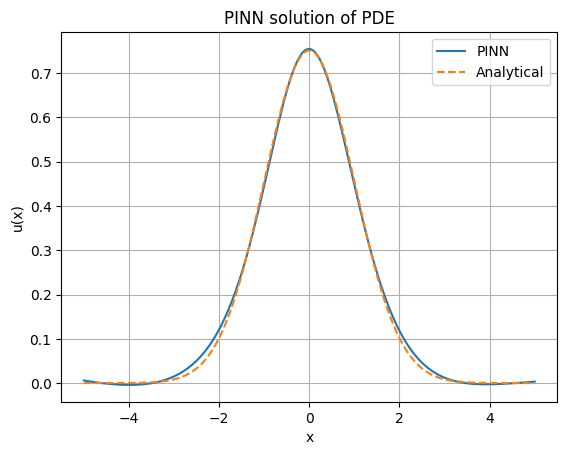

In [ ]:
torch.manual_seed(44)
np.random.seed(25)

# pinn = tiSchrodingerI(
#     device=device, 
#     num_points=100, 
#     state=4,
#     loss_pde_factor = 1,
#     loss_bc_factor = 100,
#     loss_norm_factor = 1,
#     loss_norm_exp_factor = 10
#     ).to(device)

pinn = tiSchrodingerII(
    device=device, 
    num_points=100, 
    state=0,
    loss_pde_factor = 3,
    loss_bc_factor = 1,
    loss_norm_factor = 1,
    loss_norm_exp_factor = 1
    ).to(device)


pinn.apply(init_weights)
optimizer = torch.optim.Adam(
    #list(pinn.net.parameters()) + [pinn.E],
    list(pinn.net.parameters()),
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[2000], gamma=0.1  # At epoch 8000, lr *= 0.1
)

epochs = 1000
num_batches = 1

dataset = TensorDataset(pinn.x_interior)
batch_size = int(len(dataset) / num_batches)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for epoch in range(epochs):
    for (x_batch,) in dataloader:
        optimizer.zero_grad()
        loss, loss_dict = pinn.loss(x_batch)
        loss.backward()
        optimizer.step()
    # scheduler.step()  # Step the scheduler at the end of each epoch

    if epoch % (epochs/10) == 0:
        #print(f"Epoch {epoch}, E = {pinn.E}, loss = {loss.item():.3e}, lr = {optimizer.param_groups[0]['lr']:.1e}")
        print(f"Epoch {epoch}")
        print(f"    E = {pinn.E}, norm = {loss_dict['norm'].item():.3e}, loss = {loss.item():.3e}")
        print(f"    loss_pde = {loss_dict['loss_pde'].item():.3e}, loss_bc = {loss_dict['loss_bc'].item():.3e}, loss_norm = {loss_dict['loss_norm'].item():.3e}")
        # print("loss_norm", loss_norm.item())
        # print("norm", norm.item())
        #print(f"Epoch {epoch}, E = {pinn.E.item():.4f}, loss = {loss.item():.3e}, lr = {optimizer.param_groups[0]['lr']:.1e}")



# Evaluate
u_pred = pinn(pinn.x_test).detach().cpu().numpy()

# Plot
plt.plot(pinn.x_test.cpu(), -u_pred, label="PINN")
plt.plot(pinn.x_test.cpu(), pinn.u_true, '--', label="Analytical")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN solution of PDE")
plt.grid(True)
plt.show()

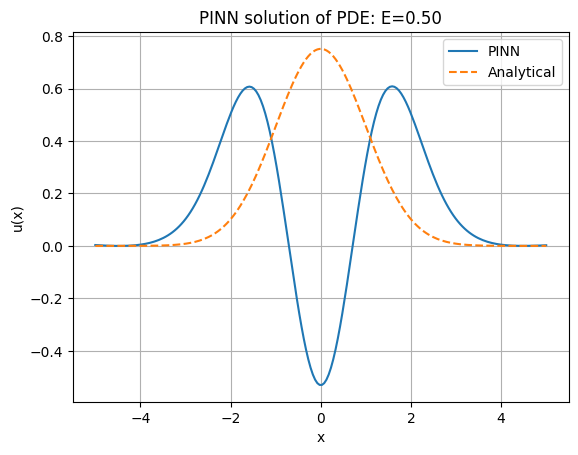

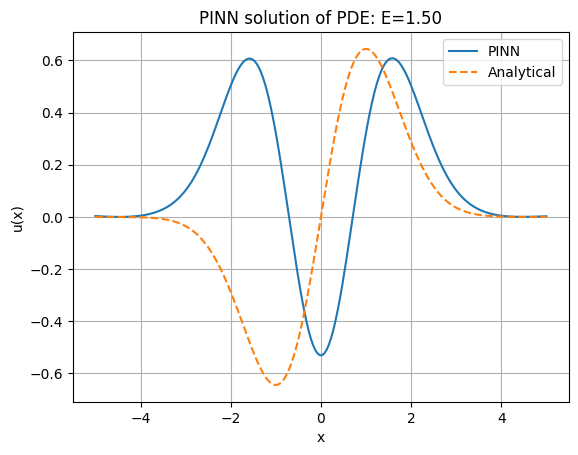

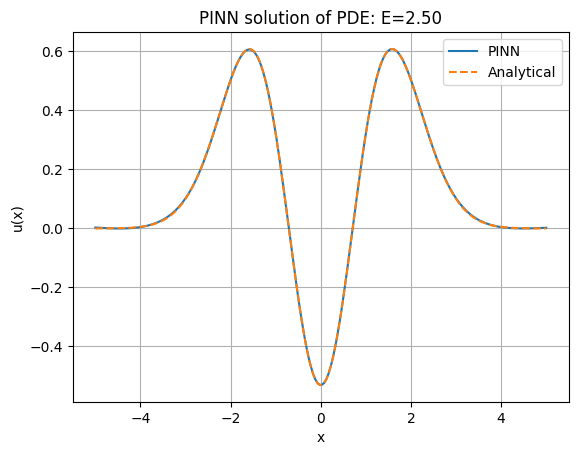

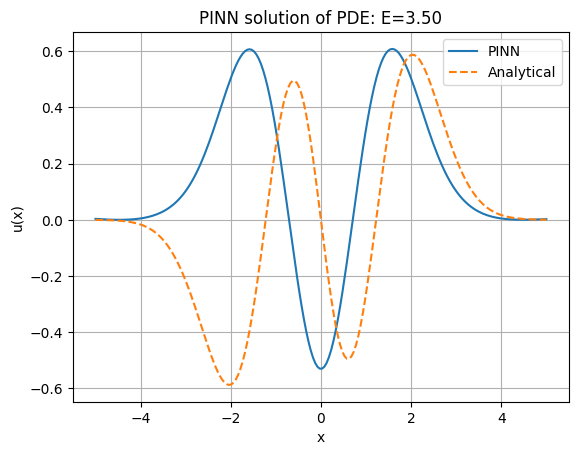

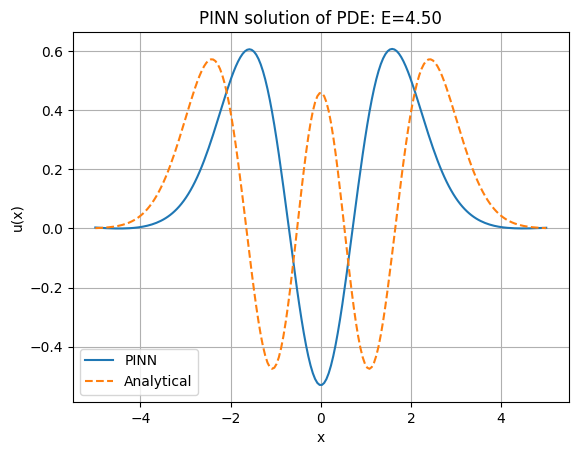

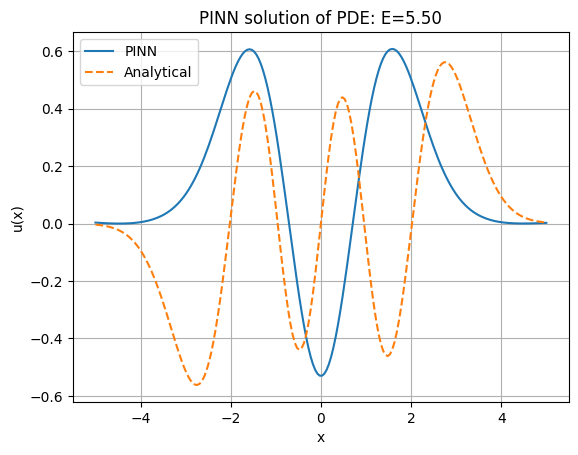

In [ ]:
from scipy.special import hermite
from scipy.special import factorial
x_test = np.linspace(-5,5,200)

def u_true_func(x, n):
    """Calculate the true solution for the nth state."""
    Hn = hermite(n)
    return (1.0 / np.sqrt(2**n * factorial(n))) * (1 / np.pi**0.25) * Hn(x) * np.exp(-x**2 / 2)

# plot
for n in range(6):
    plt.plot(pinn.x_test.cpu(), -u_pred, label="PINN")
    plt.plot(x_test, u_true_func(x_test,n), '--', label="Analytical")
    plt.legend()
    plt.title(f"E={n+1/2:.1f}")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(f"PINN solution of PDE: E={n+1/2:.2f}")
    plt.grid(True)
    plt.show()